In [1]:
import numpy as np
import xarray as xr

import matplotlib as mpl
#mpl.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
#import matplotlib.ticker as ticker
from matplotlib import ticker, cm

import pandas as pd
import os
import datetime
#import seaborn as sns
import timeit
import random
from dask.diagnostics import ProgressBar
from functools import partial

#fft packages
from scipy import fftpack
import math
from scipy import fft
from scipy import ndimage
from scipy import signal


In [ ]:
#swicth back to plotting defaults
#plt.rcdefaults()


In [2]:
#%% plot parameters
mpl.rcParams['axes.linewidth'] = 2.0 #set the value globally
plt.rc('font', family='serif',size = 18)  # controls default text layout
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=18)  # fontsize of the figure title

#sns.set()
#plt.minorticks_on()

plt.rc('text', usetex=False)


In [3]:
ProgressBar().register()

In [56]:
def _subset_process_time(ds,var,iop):
    
    #subset for the variable(s)
    ds = ds[var]
    ds['time'] = ds.time.dt.round('T')
    #IOP02
    if iop=='iop02': ds['time'] = pd.to_datetime('2019-08-22') + ds['time'].values
    #IOP03
    if iop=='iop03': ds['time'] = pd.to_datetime('2019-09-24') + ds['time'].values
    return(ds)

def _process_time(ds,iop):
    #round time to the nearest minute (30minute for PALM output)
    ds['time'] = ds.time.dt.round('T')
    #IOP02
    if iop=='iop02':ds['time'] = pd.to_datetime('2019-08-22') + ds['time'].values
    #IOP03
    if iop=='iop03':ds['time'] = pd.to_datetime('2019-09-24') + ds['time'].values    
    return(ds)

#function to concatenate all files for an ensemble member and if needed read in all ensemble members
def open_concat_member_files(ensemble_numbers,file,iop):
    data_list = []
    #loop through ensemble members
    if np.size(ensemble_numbers) > 1:
        for member_num in ensemble_numbers:    

            start_time = timeit.default_timer()
            if iop=='iop02': source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP2/ensemble.member.'+str(member_num) 
            #file = 'DATA_3D_AV_NETCDF_N02slice' 

            #Make a folder list and read in all the files from those folders. 
            folder_list = os.listdir(source_folder) 
            folder_list.sort() 
            file_list = [] 
            for folder in folder_list: 
                file_list.append(source_folder + '/' +folder+'/'+file) 
            file_list.sort()
            print(folder_list)

            #combine all the data along the time dimenstion 
            #don't combine them sequentially, but infer the sequence from coordinate values 
            #do this in parallel 
            #pull in only those values with a time dimension 
            var = ['w','theta','q','wtheta','wq']
            partial_func = partial(_subset_process_time, var=var,iop=iop)
            ds = xr.open_mfdataset(file_list,preprocess=partial_func) 
            ds.close() 
            print('Member',str(member_num),'finished collecting data')    
            #subset for time and day and collect into another list
            #for day1
            data_list.append(ds)
            elapsed = timeit.default_timer() - start_time
            print('Done with member',str(member_num),' Time elapsed ',elapsed, 'seconds')
        return(data_list)
            
    else:
        member_num =ensemble_numbers

        #loop through ensemble members
        start_time = timeit.default_timer()
        #IOP02
        if iop=='iop02':source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP2/ensemble.member.'+str(member_num) 
        #IOP03
        if iop=='iop03':source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP03/OUTPUT/ensemble.member.'+str(member_num) 
        
        #file = 'DATA_3D_AV_NETCDF_N03slice' 
        #file = 'DATA_1D_PR_NETCDF_N02slice' 

        #Make a folder list and read in all the files from those folders. 
        folder_list = os.listdir(source_folder) 
        folder_list.sort() 
        file_list = [] 
        for folder in folder_list: 
            file_list.append(source_folder + '/' +folder+'/'+file) 
        file_list.sort()
        print(folder_list)
        
        #combine all the data along the time dimenstion 
        partial_func = partial(_process_time,iop=iop)    
        ds = xr.open_mfdataset(file_list,preprocess=partial_func) 
        ds.close() 
        print('Member',str(member_num),'finished collecting data')    
        #subset for time and day and collect into another list
        #for day1
        #data_list.append(ds)
        elapsed = timeit.default_timer() - start_time
        print('Done with member',str(member_num),' Time elapsed ',elapsed, 'seconds')
        return(ds)

def calculate_turb_flux(ds):
    #subset for the variable(s)
    ds['theta_interpolated'] = ds.theta.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w)
    ds['q_interpolated'] = ds.q.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w)

    ds['wtheta_turb'] = ds['wtheta'] - ds.w*ds.theta_interpolated
    ds['wq_turb'] = ds['wq'] - ds.w*ds.q_interpolated


    ds['wtheta_turb_energy'] = ds['wtheta_turb']*1.17*1005
    ds['wq_turb_energy'] = ds['wq_turb']*1.17*1000*2501

    return ds

#from Luise Wanner
def belltaper(var, n): #-- following Stull 1999
    W = [] # weight function 
    for i in np.arange(n):
        if (i/n > 0.1) & (i/n < 0.9):
            W.append(1)
        else:
            W.append(math.sin(np.pi*i/n)**2)
    out = var * W
    return(out)

def GetPSD1D(psd2D):
    h  = psd2D.shape[0]
    w  = psd2D.shape[1]
    wc = w//2
    hc = h//2

    # create an array of integer radial distances from the center
    Y, X = np.ogrid[0:h, 0:w]
    r    = np.hypot(X - wc, Y - hc).astype(int)

    # SUM all psd2D pixels with label 'r' for 0<=r<=wc
    # NOTE: this will miss power contributions in 'corners' r>wc
    psd1D = ndimage.mean(psd2D, r, index=np.arange(0, wc))

    return psd1D

def open_nc(fname):
    with xr.open_dataset(fname) as ds:
        ds.load()
    
    return ds


## Compare the measured half-hourly tower data for soil T and soil q with simulated values from the child2 domain. 

#### IOP02

Tower data

In [5]:
tower_data = xr.open_dataset('tower_and_meta_data_20230505.nc')
tower_data.close()

#calculate time variable and offset for UTC
tower_data['time'] = (tower_data.DOY+tower_data.hour/24+tower_data.minute/60/24 - 5/24)
tower_data['time'] = tower_data['time']
#set local(CDT) time as a coordinate
tower_data = tower_data.set_coords(['time'])

#subset for 2019 Aug 22 and 23
f1 = tower_data.time>=234
f2 = tower_data.time<=236
#subset for 2019 Sep 24 and Sep25
# f1 = tower_data.time>=267
# f2 = tower_data.time<=269

tower_data = tower_data.where(f1 & f2, drop=True)

#subset all >30m towers 
tower_data = tower_data.where(tower_data.z_meas>=30, drop=True)

tower_name_list = tower_data.tower.values

#subset for time, because simulated tower data only start at 5:00 CDT on 23rd and go on till 20:00 on 24
#for IOP02
tower_data = tower_data.isel(timestep=slice(9,88))



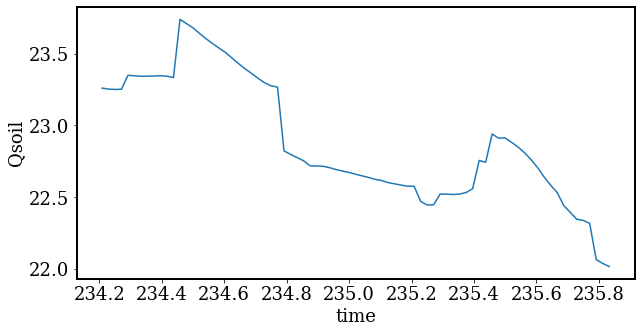

In [8]:
fig = plt.figure(figsize=(10,5))
ax = fig.subplots(1,1)

ax = tower_data.Qsoil.mean('tower').plot(x='time')

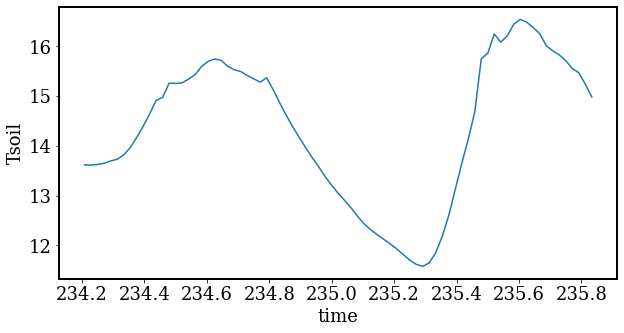

In [9]:
fig = plt.figure(figsize=(10,5))
ax = fig.subplots(1,1)

ax = tower_data.Tsoil.mean('tower').plot(x='time')

In [15]:
ensemble_member_ds_N03_iop02 = open_concat_member_files(8,'DATA_3D_NETCDF_N03slice','iop02')
ensemble_member_ds_N03_iop02

['04.ches_IOP2.1455', '05. ches_IOP2.31525', '06.ches_IOP2.1409', '07.ches_IOP2.31095', '1.ches_IOP2.11058', '2.ches_IOP2.20781', '3.ches_IOP2.1521']
Member 8 finished collecting data
Done with member 8  Time elapsed  1.8993529886938632 seconds


<xarray.Dataset>
Dimensions:                (x: 2000, time: 88, y: 2000, xu: 2000, yv: 2000,
                            zu_3d: 27, zw_3d: 27, zs_3d: 8, zpc_3d: 10)
Coordinates:
  * x                      (x) float64 3.0 9.0 15.0 ... 1.199e+04 1.2e+04
  * y                      (y) float64 3.0 9.0 15.0 ... 1.199e+04 1.2e+04
  * xu                     (xu) float64 0.0 6.0 12.0 ... 1.199e+04 1.199e+04
  * yv                     (yv) float64 0.0 6.0 12.0 ... 1.199e+04 1.199e+04
  * time                   (time) datetime64[ns] 2019-08-22T00:30:00 ... 2019...
  * zu_3d                  (zu_3d) float64 0.0 2.0 6.0 10.0 ... 94.0 98.0 102.0
  * zw_3d                  (zw_3d) float64 0.0 4.0 8.0 12.0 ... 96.0 100.0 104.0
  * zs_3d                  (zs_3d) float64 -0.005 -0.02 -0.05 ... -0.4 -0.8 -2.0
  * zpc_3d                 (zpc_3d) float64 0.0 2.0 6.0 10.0 ... 26.0 30.0 34.0
Data variables: (12/28)
    E_UTM                  (time, x) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    N_UTM                  (time, y) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    Eu_UTM                 (time, xu) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    Nu_UTM                 (time, y) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    Ev_UTM                 (time, x) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    Nv_UTM                 (time, yv) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    ...                     ...
    rh                     (time, zu_3d, y, x) float32 dask.array<chunksize=(14, 27, 2000, 2000), meta=np.ndarray>
    m_soil                 (time, zs_3d, y, x) float32 dask.array<chunksize=(14, 8, 2000, 2000), meta=np.ndarray>
    t_soil                 (time, zs_3d, y, x) float32 dask.array<chunksize=(14, 8, 2000, 2000), meta=np.ndarray>
    pcm_heatrate           (time, zpc_3d, y, x) float32 dask.array<chunksize=(14, 10, 2000, 2000), meta=np.ndarray>
    pcm_transpirationrate  (time, zpc_3d, y, x) float32 dask.array<chunksize=(14, 10, 2000, 2000), meta=np.ndarray>
    pcm_latentrate         (time, zpc_3d, y, x) float32 dask.array<chunksize=(14, 10, 2000, 2000), meta=np.ndarray>
Attributes: (12/27)
    title:           PALM 21.10-rc.2  run: ches_IOP2.01  nest-id: 03  host: b...
    Conventions:     CF-1.7
    creation_time:   2022-07-27 14:43:15 -06
    data_content:    3d
    version:         2
    origin_time:     2019-08-22 05:00:00 +00
    ...              ...
    source:          PALM 21.10-rc.2
    references:      
    keywords:        example, PALM-4U
    licence:         
    comment:         Generic crossing example
    VAR_LIST:        ;u;v;w;e;theta;q;s;rh;m_soil;t_soil;pcm_heatrate;pcm_tra...

In [22]:
ensemble_member_ds_N03_iop02 = open_concat_member_files(1,'DATA_3D_NETCDF_N03slice','iop02')

x_list = [2217,3981,6159,8619,9225,9669,723,3249,5391,6801,8091,9537]
y_list = [9147,9951,9309,7335,9465,8019,2799,3441,5499,5199,4161,3333]
site_name = ['nw1', 'nw4', 'ne1', 'ne2', 'ne3', 'ne4', 'sw1', 'sw3','sw4', 'se2', 'se3', 'se6']

#list to club all simulated data
site_thetas_list = []
site_qs_list = []


#looping through each site first
for i, site in enumerate(site_name):        

    #list to combine the data for one site
    thetas_list = []
    qs_list = []

    #first collect data at all times for one site

    ds = ensemble_member_ds_N03_iop02.sel(x=x_list[i],y=y_list[i]).sel(zs_3d = slice (0,-0.05))[['m_soil','t_soil']]

    #read in variables to data arrays
    #for each tower location combine the flux data        

    thetas_ds = ds.t_soil.mean('zs_3d')
    qs_ds = ds.m_soil.mean('zs_3d')

    site_thetas_list.append(thetas_ds)
    site_qs_list.append(qs_ds)   

    print('done!' + site)

thetas_all_sites_ds = xr.concat(site_thetas_list, pd.Index(site_name,name='tower')).compute()
qs_all_sites_ds = xr.concat(site_qs_list, pd.Index(site_name,name='tower')).compute()



['01.ches_IOP2.24050', '02.ches_IOP2.10023', '03.ches_IOP2.28390', '04.ches_IOP2.20941', '05.ches_IOP2.13864', '06.ches_IOP2.31028', '07.ches_IOP2.19931', '08.ches_IOP2.19743']
Member 1 finished collecting data
Done with member 1  Time elapsed  0.32322739623486996 seconds
done!nw1
done!nw4
done!ne1
done!ne2
done!ne3
done!ne4
done!sw1
done!sw3
done!sw4
done!se2
done!se3
done!se6
[########################################] | 100% Completed | 13.10 s
[########################################] | 100% Completed | 13.61 s


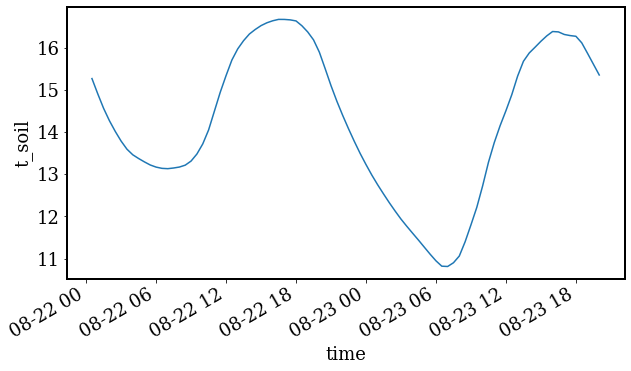

In [30]:
fig = plt.figure(figsize=(10,5))
ax = fig.subplots(1,1)

(thetas_all_sites_ds.mean('tower')-273.15).plot()

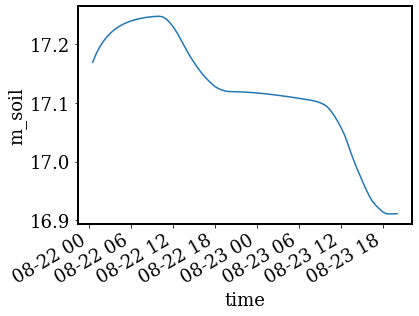

In [29]:
(qs_all_sites_ds.mean('tower')*100).plot()

They look good :) the match is not bad and I'm releived. 

## Representative plots for surface fluxes for iop02 and iop03

In [5]:
ensemble_member_ds_2_P_iop02 = open_concat_member_files(2,'DATA_3D_AV_NETCDFslice','iop02')
ensemble_member_ds_2_N02_iop02 = open_concat_member_files(2,'DATA_3D_AV_NETCDF_N02slice','iop02')
ensemble_member_ds_2_N03_iop02 = open_concat_member_files(2,'DATA_3D_AV_NETCDF_N03slice','iop02')

['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.8227843060158193 seconds
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  1.1370292226783931 seconds
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.6302730259485543 seconds


In [6]:
ensemble_member_ds_2_P_iop03 = open_concat_member_files(2,'DATA_3D_AV_NETCDFslice','iop03')
ensemble_member_ds_2_N02_iop03 = open_concat_member_files(2,'DATA_3D_AV_NETCDF_N02slice','iop03')
ensemble_member_ds_2_N03_iop03 = open_concat_member_files(2,'DATA_3D_AV_NETCDF_N03slice','iop03')

['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.4822484143078327 seconds
['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  1.5939875743351877 seconds
['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.4239205839112401 seconds


In [7]:
ensemble_member_surf_ds_2_P_iop02 = open_concat_member_files(2,'DATA_2D_XY_AV_NETCDFslice','iop02')
ensemble_member_surf_ds_2_N02_iop02 = open_concat_member_files(2,'DATA_2D_XY_AV_NETCDF_N02slice','iop02')
ensemble_member_surf_ds_2_N03_iop02 = open_concat_member_files(2,'DATA_2D_XY_AV_NETCDF_N03slice','iop02')

['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  1.9496862348169088 seconds
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  1.773945248220116 seconds
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  1.2727445308119059 seconds


In [8]:
ensemble_member_surf_ds_2_P_iop03 = open_concat_member_files(2,'DATA_2D_XY_AV_NETCDFslice','iop03')
ensemble_member_surf_ds_2_N02_iop03 = open_concat_member_files(2,'DATA_2D_XY_AV_NETCDF_N02slice','iop03')
ensemble_member_surf_ds_2_N03_iop03 = open_concat_member_files(2,'DATA_2D_XY_AV_NETCDF_N03slice','iop03')

['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.31826961785554886 seconds
['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.2771038021892309 seconds
['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.44950881227850914 seconds


Total surface fluxes:

In [45]:
ensemble_member_ds_2_N03_iop02

<xarray.Dataset>
Dimensions:                (x: 2000, time: 88, y: 2000, xu: 2000, yv: 2000,
                            zu_3d: 27, zw_3d: 27, zpc_3d: 10)
Coordinates:
  * x                      (x) float64 3.0 9.0 15.0 ... 1.199e+04 1.2e+04
  * y                      (y) float64 3.0 9.0 15.0 ... 1.199e+04 1.2e+04
  * xu                     (xu) float64 0.0 6.0 12.0 ... 1.199e+04 1.199e+04
  * yv                     (yv) float64 0.0 6.0 12.0 ... 1.199e+04 1.199e+04
  * time                   (time) datetime64[ns] 2019-08-22T00:30:00 ... 2019...
  * zu_3d                  (zu_3d) float64 0.0 2.0 6.0 10.0 ... 94.0 98.0 102.0
  * zw_3d                  (zw_3d) float64 0.0 4.0 8.0 12.0 ... 96.0 100.0 104.0
  * zpc_3d                 (zpc_3d) float64 0.0 2.0 6.0 10.0 ... 26.0 30.0 34.0
Data variables: (12/35)
    E_UTM                  (time, x) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    N_UTM                  (time, y) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    Eu_UTM                 (time, xu) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    Nu_UTM                 (time, y) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    Ev_UTM                 (time, x) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    Nv_UTM                 (time, yv) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    ...                     ...
    wtheta                 (time, zw_3d, y, x) float32 dask.array<chunksize=(14, 27, 2000, 2000), meta=np.ndarray>
    wq                     (time, zw_3d, y, x) float32 dask.array<chunksize=(14, 27, 2000, 2000), meta=np.ndarray>
    ws                     (time, zw_3d, y, x) float32 dask.array<chunksize=(14, 27, 2000, 2000), meta=np.ndarray>
    pcm_heatrate           (time, zpc_3d, y, x) float32 dask.array<chunksize=(14, 10, 2000, 2000), meta=np.ndarray>
    pcm_transpirationrate  (time, zpc_3d, y, x) float32 dask.array<chunksize=(14, 10, 2000, 2000), meta=np.ndarray>
    pcm_latentrate         (time, zpc_3d, y, x) float32 dask.array<chunksize=(14, 10, 2000, 2000), meta=np.ndarray>
Attributes: (12/28)
    title:           PALM 21.10-rc.2  run: ches_IOP2.01  nest-id: 03  host: b...
    Conventions:     CF-1.7
    creation_time:   2022-08-16 02:54:38 -06
    data_content:    3d_av
    version:         2
    origin_time:     2019-08-22 05:00:00 +00
    ...              ...
    references:      
    keywords:        example, PALM-4U
    licence:         
    comment:         Generic crossing example
    time_avg:         1800.0 s avg
    VAR_LIST:        ;u;v;w;e;uu;vv;ww;uv;uw;vw;theta;q;s;rh;wtheta;wq;ws;pcm...

[########################################] | 100% Completed | 504.20 ms
[########################################] | 100% Completed | 504.27 ms


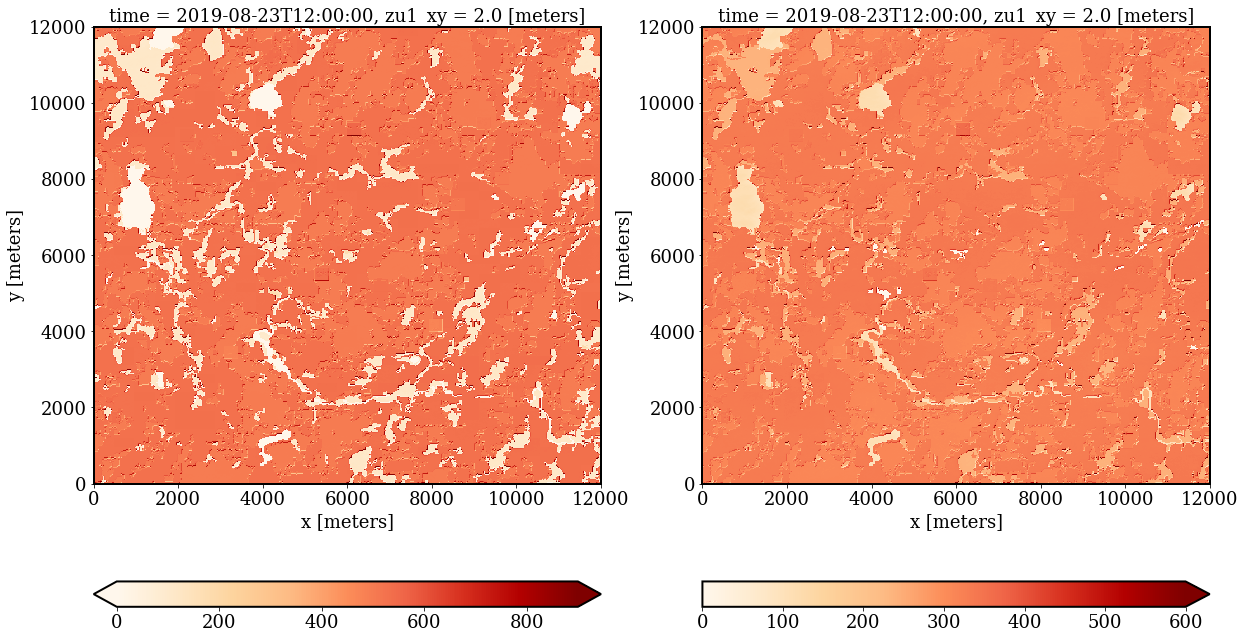

In [50]:
###---------------------------------------------------
#PCM fluxes in the domains

N03_H_PCM = (ensemble_member_ds_2_N03_iop02.pcm_heatrate.sel(time='2019-08-23T12:00:00.000000000').sum('zpc_3d')*1.17*1005*4)

N03_LE_PCM = (ensemble_member_ds_2_N03_iop02.pcm_transpirationrate.sel(time='2019-08-23T12:00:00.000000000').sum('zpc_3d')*2.5E+06 * 1.17*4)


###---------------------------------------------------
#surface fluxes in the domains
N03_H_surf = ensemble_member_surf_ds_2_N03_iop02['shf*_xy'].isel(time=71)

N03_LE_surf = ensemble_member_surf_ds_2_N03_iop02['qsws*_xy'].isel(time=71)

###---------------------------------------------------

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,12))

(N03_H_surf+N03_H_PCM).plot(ax=ax1,cmap='OrRd',vmin=0,vmax=900,cbar_kwargs={'location':'bottom'})
(N03_LE_surf+N03_LE_PCM).plot(ax=ax2,cmap='OrRd',vmin=0,vmax=600,cbar_kwargs={'location':'bottom'})#,vmin=0,vmax=400,


In [43]:
#ensemble_member_ds_2_P_iop02 = open_concat_member_files(2,'DATA_3D_AV_NETCDFslice','iop02')
path = '/bog/incoming/CHEESEHEAD/palm/realistic_runs/ches_IOP2/INPUT/'
fname = 'ches_IOP2_static_N02'
file = path+fname
with xr.open_dataset(file) as ches_static_ds_iop02:
    ches_static_ds_iop02.load()
ches_static_ds_iop02

<xarray.Dataset>
Dimensions:            (x: 900, y: 1008, z: 150, zlad: 5, zsoil: 10,
                        nsurface_fraction: 3, nwater_pars: 7)
Coordinates:
  * x                  (x) float32 15.0 45.0 75.0 ... 2.696e+04 2.698e+04
  * y                  (y) float32 15.0 45.0 75.0 ... 3.02e+04 3.022e+04
  * z                  (z) float32 0.0 6.0 18.0 ... 1.758e+03 1.77e+03 1.782e+03
  * zlad               (zlad) float32 0.0 6.0 18.0 30.0 42.0
  * zsoil              (zsoil) float32 -0.0005 0.0055 0.015 0.03 ... 0.4 0.8 2.0
  * nsurface_fraction  (nsurface_fraction) int32 0 1 2
  * nwater_pars        (nwater_pars) int32 0 1 2 3 4 5 6
Data variables:
    zt                 (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    pavement_type      (y, x) float32 nan nan nan nan nan ... nan nan nan nan
    soil_type          (y, x) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    surface_fraction   (nsurface_fraction, y, x) float32 1.0 1.0 1.0 ... 0.0 0.0
    vegetation_type    (y, x) float32 3.0 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0
    water_type         (y, x) float32 nan nan nan nan nan ... nan nan nan nan
    lad                (zlad, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    water_pars         (nwater_pars, y, x) float32 nan nan nan ... nan nan nan
Attributes: (12/20)
    title:           test static driver
    author:          Luise Wanner, luise.wanner at kit.edu, Sreenath Paleri, ...
    institution:     IMK-IFU,Karlsruhe Institute of Technology, AOSS UW Madison
    comment:         Generic crossing example
    creation_date:   21-11-01 19:21:16 +00
    history:         
    ...              ...
    origin_lat:      45.8083992
    origin_time:     2019-03-06 10:00:00 +00
    origin_x:        698420.49
    origin_y:        5075931.26
    origin_z:        470.0
    rotation_angle:  0.0

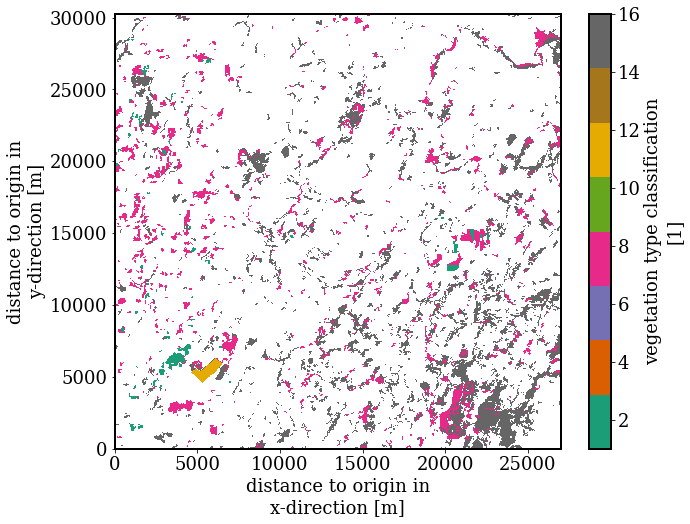

In [31]:

fig, ax = plt.subplots(1,1,figsize=(10,8))
ches_static_ds_iop02.vegetation_type.where(ches_static_ds_iop02.vegetation_type!=3).plot(ax = ax, cmap = 'Dark2')
#ches_static_ds_iop02.water_type.plot(ax = ax, cmap='tab20c')
#ches_static_ds_iop02.pavement_type.plot(ax = ax, cmap='tab20c')


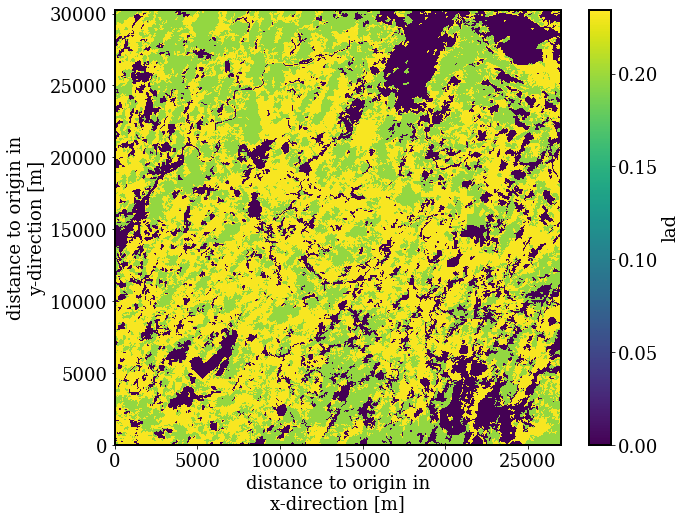

In [28]:

fig, ax = plt.subplots(1,1,figsize=(10,8))
ches_static_ds_iop02.lad.sum('zlad').plot(ax = ax, cmap='viridis')

I'll just extract the time series for surface forcings at the tower locations

In [74]:
#setting the iop and ensemble numbers needed
iop = 'iop02' 
ensemble_numbers = np.arange(1,9)

#loop through each member,
#extract and concatenate the data
#extract profile data at each tower location
#calculate the turbulent fluxes and extract theta,q 
#output an xarray data array per each ensemble member and then concatenate it outside of the loop
wtheta_all_members_list = []
wq_all_members_list = []

for member_num in ensemble_numbers:
    
    ensemble_member_ds_N03_iop02 = open_concat_member_files(member_num,'DATA_3D_AV_NETCDF_N03slice',iop)
    ensemble_member_surf_ds_N03_iop02 = open_concat_member_files(member_num,'DATA_2D_XY_AV_NETCDF_N03slice',iop)

    x_list = [2217,3981,6159,8619,9225,9669,723,3249,5391,6801,8091,9537]
    y_list = [9147,9951,9309,7335,9465,8019,2799,3441,5499,5199,4161,3333]
    site_name = ['nw1', 'nw4', 'ne1', 'ne2', 'ne3', 'ne4', 'sw1', 'sw3','sw4', 'se2', 'se3', 'se6']

    site_wtheta_list = []
    site_wq_list = []


    #looping through each site first
    for i, site in enumerate(site_name):        

        #list to combine the data for one site
        wtheta_list = []
        wq_list = []

        #first collect data at all times for one site

        ds_PCM = ensemble_member_ds_N03_iop02.sel(x=x_list[i],y=y_list[i])
        ds_surf = ensemble_member_surf_ds_N03_iop02.sel(x=x_list[i],y=y_list[i])

        #PCM fluxes in the domains

        N03_H_PCM = (ds_PCM.pcm_heatrate.sum('zpc_3d')*1.17*1005*4)

        N03_LE_PCM = (ds_PCM.pcm_transpirationrate.sum('zpc_3d')*2.5E+06 * 1.17*4)


        ###---------------------------------------------------
        #surface fluxes in the domains
        N03_H_surf = ds_surf['shf*_xy']

        N03_LE_surf = ds_surf['qsws*_xy']


        wtheta_ds = (N03_H_PCM + N03_H_surf)
        wq_ds = (N03_LE_PCM + N03_LE_surf)

        
        site_wtheta_list.append(wtheta_ds)
        site_wq_list.append(wq_ds)   

        print('done!' + site)

    wtheta_all_sites_ds = xr.concat(site_wtheta_list, pd.Index(site_name,name='tower')).compute()
    wq_all_sites_ds = xr.concat(site_wq_list, pd.Index(site_name,name='tower')).compute()
    
    wtheta_all_members_list.append(wtheta_all_sites_ds)
    wq_all_members_list.append(wq_all_sites_ds)
    
    print('done member' + str(member_num) + '!')


['01.ches_IOP2.24050', '02.ches_IOP2.10023', '03.ches_IOP2.28390', '04.ches_IOP2.20941', '05.ches_IOP2.13864', '06.ches_IOP2.31028', '07.ches_IOP2.19931', '08.ches_IOP2.19743']
Member 1 finished collecting data
Done with member 1  Time elapsed  0.7213107771240175 seconds
['01.ches_IOP2.24050', '02.ches_IOP2.10023', '03.ches_IOP2.28390', '04.ches_IOP2.20941', '05.ches_IOP2.13864', '06.ches_IOP2.31028', '07.ches_IOP2.19931', '08.ches_IOP2.19743']
Member 1 finished collecting data
Done with member 1  Time elapsed  0.37015389977023005 seconds
done!nw1
done!nw4
done!ne1
done!ne2
done!ne3
done!ne4
done!sw1
done!sw3
done!sw4
done!se2
done!se3
done!se6
[########################################] | 100% Completed | 21.10 s
[########################################] | 100% Completed | 19.91 s
done member1!
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done 

In [76]:
# xr.concat(wtheta_all_members_list,'ensemble').to_netcdf('work/wtheta_surface_all_members.nc')
# xr.concat(wq_all_members_list,'ensemble').to_netcdf('work/wq_surface_all_members.nc')


In [77]:
wtheta_surface_simulated = open_nc('work/wtheta_surface_all_members.nc')
wtheta_surface_simulated['wtheta_surface'] = wtheta_surface_simulated['__xarray_dataarray_variable__'].rename('wtheta_surface')
wtheta_surface_simulated = wtheta_surface_simulated.drop(['__xarray_dataarray_variable__'])

wq_surface_simulated = open_nc('work/wq_surface_all_members.nc')
wq_surface_simulated['wq_surface'] = wq_surface_simulated['__xarray_dataarray_variable__'].rename('wq_surface')
wq_surface_simulated = wq_surface_simulated.drop(['__xarray_dataarray_variable__'])


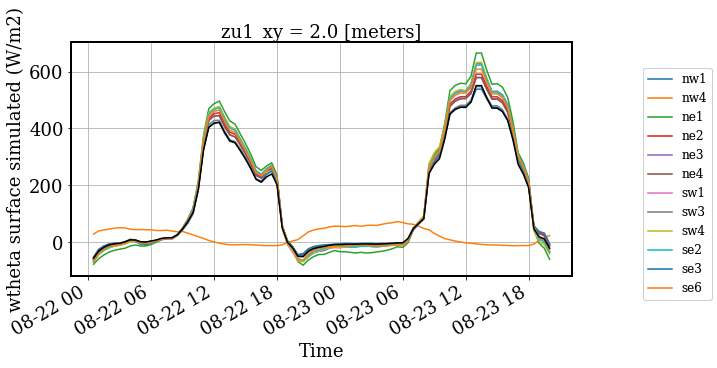

In [78]:

fig = plt.figure(figsize=(10,5))
ax = fig.subplots(1,1)
for tower_name in wtheta_surface_simulated.tower:
    wtheta_surface_simulated.wtheta_surface.mean('ensemble').sel(tower=tower_name.values).plot(ax=ax,label=str(tower_name.values),x='time')

wtheta_surface_simulated.wtheta_surface.mean('ensemble').mean('tower').plot(ax=ax,color ='black',x='time')

fig.legend(loc=7,fontsize=12)
ax.set_xlabel('Time',fontsize=18)
ax.set_ylabel('wtheta surface simulated (W/m2)',fontsize=18)
#ax.set_ylim([-0.25,0.3])
ax.grid(True)
fig.legend(loc=7,fontsize=12)
fig.tight_layout()
fig.subplots_adjust(right=0.8)


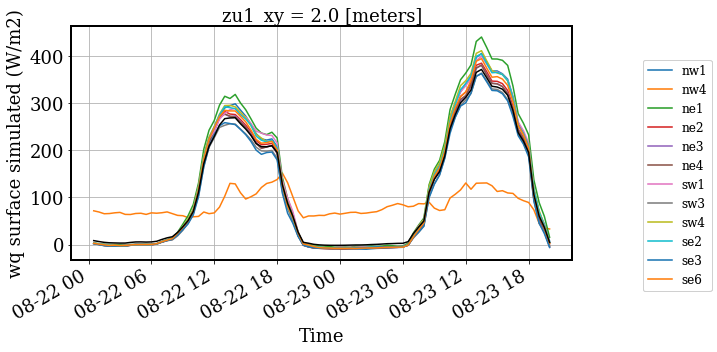

In [79]:

fig = plt.figure(figsize=(10,5))
ax = fig.subplots(1,1)
for tower_name in wtheta_surface_simulated.tower:
    wq_surface_simulated.wq_surface.mean('ensemble').sel(tower=tower_name.values).plot(ax=ax,label=str(tower_name.values),x='time')

wq_surface_simulated.wq_surface.mean('ensemble').mean('tower').plot(ax=ax,color ='black',x='time')

fig.legend(loc=7,fontsize=12)
ax.set_xlabel('Time',fontsize=18)
ax.set_ylabel('wq surface simulated (W/m2)',fontsize=18)
#ax.set_ylim([-0.25,0.3])
ax.grid(True)
fig.legend(loc=7,fontsize=12)
fig.tight_layout()
fig.subplots_adjust(right=0.8)


In [87]:
wtheta_simulated = open_nc('work/wtheta_all_members_IOP02.nc')
wq_simulated = open_nc('work/wq_all_members_IOP02.nc')
wtheta_simulated['time']= wtheta_simulated.time - pd.Timedelta(1, unit='D')
wq_simulated['time']= wq_simulated.time - pd.Timedelta(1, unit='D')

Simulated SEB residual

In [88]:
mean_surface_H = wtheta_surface_simulated.wtheta_surface.mean('ensemble').mean('tower')
mean_surface_LE = wq_surface_simulated.wq_surface.mean('ensemble').mean('tower')

mean_H = wtheta_simulated.wtheta_turb_energy.mean('ensemble').mean('tower')
mean_LE = wq_simulated.wq_turb_energy.mean('ensemble').mean('tower')

H_missing = mean_surface_H - mean_H
LE_missing = mean_surface_LE - mean_LE


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


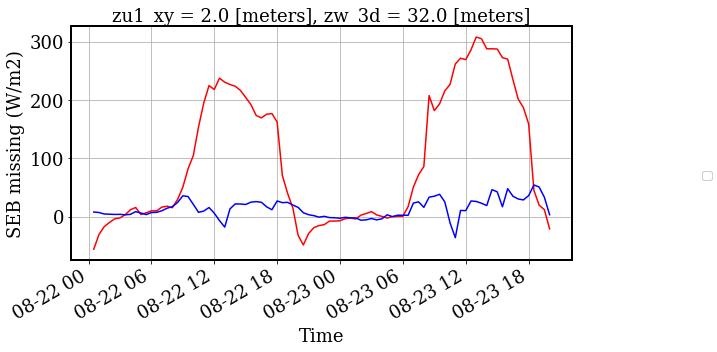

In [102]:

fig = plt.figure(figsize=(10,5))
ax = fig.subplots(1,1)

H_missing.plot(ax=ax,color ='red',x='time')
LE_missing.plot(ax=ax,color ='blue',x='time')

fig.legend(loc=7,fontsize=12)
ax.set_xlabel('Time',fontsize=18)
ax.set_ylabel('SEB missing (W/m2)',fontsize=18)
#ax.set_ylim([-0.25,0.3])
ax.grid(True)
fig.legend(loc=7,fontsize=12)
fig.tight_layout()
fig.subplots_adjust(right=0.8)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


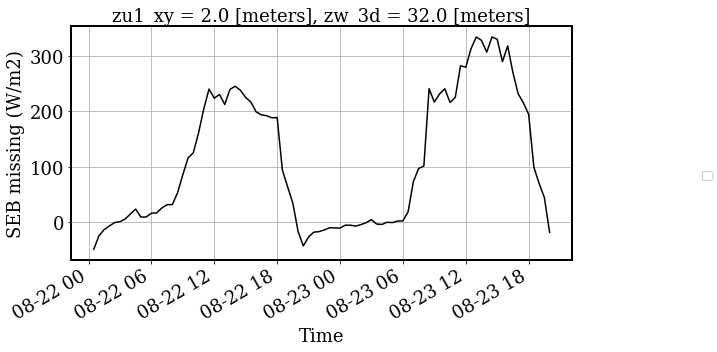

In [103]:

fig = plt.figure(figsize=(10,5))
ax = fig.subplots(1,1)

(H_missing+LE_missing).plot(ax=ax,color ='black',x='time')

fig.legend(loc=7,fontsize=12)
ax.set_xlabel('Time',fontsize=18)
ax.set_ylabel('SEB missing (W/m2)',fontsize=18)
#ax.set_ylim([-0.25,0.3])
ax.grid(True)
fig.legend(loc=7,fontsize=12)
fig.tight_layout()
fig.subplots_adjust(right=0.8)

The really high values for H is very weird. I should check flux profiles, with absolute magnitudes tomorrow firstly.

See how much of dispersive flux transport exists between H and LE in absolute magnitudes..

As MS suggested, it could be that not all of this heat goes into the atmosphere, some of it goes to soil and then to canopy heat storage.

Checking ground heat flux.

In [92]:
ensemble_member_surf_ds_N03_iop02

<xarray.Dataset>
Dimensions:         (zu_xy: 7, time: 88, x: 2000, y: 2000, xu: 2000, yv: 2000,
                     zw_xy: 7, zu1_xy: 1)
Coordinates:
  * zu_xy           (zu_xy) float64 0.0 2.0 22.0 30.0 50.0 102.0 202.0
  * x               (x) float64 3.0 9.0 15.0 ... 1.198e+04 1.199e+04 1.2e+04
  * y               (y) float64 3.0 9.0 15.0 ... 1.198e+04 1.199e+04 1.2e+04
  * xu              (xu) float64 0.0 6.0 12.0 ... 1.198e+04 1.199e+04 1.199e+04
  * yv              (yv) float64 0.0 6.0 12.0 ... 1.198e+04 1.199e+04 1.199e+04
  * time            (time) datetime64[ns] 2019-08-22T00:30:00 ... 2019-08-23T...
  * zw_xy           (zw_xy) float64 0.0 4.0 24.0 32.0 52.0 104.0 204.0
  * zu1_xy          (zu1_xy) float64 2.0
Data variables: (12/35)
    ind_z_xy        (time, zu_xy) float64 dask.array<chunksize=(14, 7), meta=np.ndarray>
    E_UTM           (time, x) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    N_UTM           (time, y) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    Eu_UTM          (time, xu) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    Nu_UTM          (time, y) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    Ev_UTM          (time, x) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    ...              ...
    t*_xy           (time, zu1_xy, y, x) float32 dask.array<chunksize=(14, 1, 2000, 2000), meta=np.ndarray>
    tsurf*_xy       (time, zu1_xy, y, x) float32 dask.array<chunksize=(14, 1, 2000, 2000), meta=np.ndarray>
    rad_lw_in*_xy   (time, zu1_xy, y, x) float32 dask.array<chunksize=(14, 1, 2000, 2000), meta=np.ndarray>
    rad_lw_out*_xy  (time, zu1_xy, y, x) float32 dask.array<chunksize=(14, 1, 2000, 2000), meta=np.ndarray>
    rad_sw_in*_xy   (time, zu1_xy, y, x) float32 dask.array<chunksize=(14, 1, 2000, 2000), meta=np.ndarray>
    rad_sw_out*_xy  (time, zu1_xy, y, x) float32 dask.array<chunksize=(14, 1, 2000, 2000), meta=np.ndarray>
Attributes: (12/28)
    title:           PALM 21.10-rc.2  run: ches_IOP2.01  nest-id: 03  host: b...
    Conventions:     CF-1.7
    creation_time:   2022-07-27 14:43:15 -06
    data_content:    xy_av
    version:         2
    origin_time:     2019-08-22 05:00:00 +00
    ...              ...
    references:      
    keywords:        example, PALM-4U
    licence:         
    comment:         Generic crossing example
    time_avg:         1800.0 s avg
    VAR_LIST:        ;u_xy;v_xy;w_xy;theta_xy;q_xy;s_xy;shf*_xy;qsws*_xy;ghf*...

In [93]:
#setting the iop and ensemble numbers needed
iop = 'iop02' 
ensemble_numbers = np.arange(1,9)

#loop through each member,
#extract and concatenate the data
#output an xarray data array per each ensemble member and then concatenate it outside of the loop
ghf_all_members_list = []

for member_num in ensemble_numbers:
    
    ensemble_member_surf_ds_N03_iop02 = open_concat_member_files(member_num,'DATA_2D_XY_AV_NETCDF_N03slice',iop)

    x_list = [2217,3981,6159,8619,9225,9669,723,3249,5391,6801,8091,9537]
    y_list = [9147,9951,9309,7335,9465,8019,2799,3441,5499,5199,4161,3333]
    site_name = ['nw1', 'nw4', 'ne1', 'ne2', 'ne3', 'ne4', 'sw1', 'sw3','sw4', 'se2', 'se3', 'se6']

    site_ghf_list = []


    #looping through each site first
    for i, site in enumerate(site_name):        


        #first collect data at all times for one site

        ds_surf = ensemble_member_surf_ds_N03_iop02.sel(x=x_list[i],y=y_list[i])

        #surface fluxes in the domains
        ghf_ds = ds_surf['ghf*_xy']
        
        site_ghf_list.append(ghf_ds)
        print('done!' + site)

    ghf_all_sites_ds = xr.concat(site_ghf_list, pd.Index(site_name,name='tower')).compute()
    
    ghf_all_members_list.append(ghf_all_sites_ds)    
    print('done member' + str(member_num) + '!')

['01.ches_IOP2.24050', '02.ches_IOP2.10023', '03.ches_IOP2.28390', '04.ches_IOP2.20941', '05.ches_IOP2.13864', '06.ches_IOP2.31028', '07.ches_IOP2.19931', '08.ches_IOP2.19743']
Member 1 finished collecting data
Done with member 1  Time elapsed  0.75743408780545 seconds
done!nw1
done!nw4
done!ne1
done!ne2
done!ne3
done!ne4
done!sw1
done!sw3
done!sw4
done!se2
done!se3
done!se6
[########################################] | 100% Completed | 1.82 sms
done member1!
['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.27753171091899276 seconds
done!nw1
done!nw4
done!ne1
done!ne2
done!ne3
done!ne4
done!sw1
done!sw3
done!sw4
done!se2
done!se3
done!se6
[########################################] | 100% Completed | 2.63 sms
done member2!
['01.ches_IOP2.2199', '02.ches_IOP2.11581', '03.ches_IOP2.26923', '04.ches_IOP2.16339', '05.ch

In [95]:
# xr.concat(ghf_all_members_list,'ensemble').to_netcdf('work/ghf_all_members_list.nc')


In [98]:
ghf_simulated = open_nc('work/ghf_all_members_list.nc')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


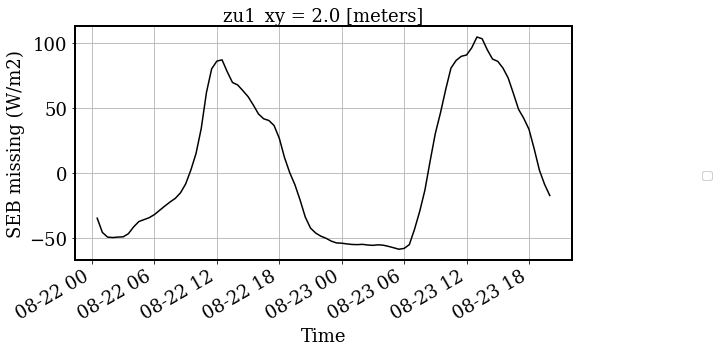

In [100]:

fig = plt.figure(figsize=(10,5))
ax = fig.subplots(1,1)

ghf_simulated['ghf*_xy'].mean('ensemble').mean('tower').plot(ax=ax,color ='black',x='time')

fig.legend(loc=7,fontsize=12)
ax.set_xlabel('Time',fontsize=18)
ax.set_ylabel('SEB missing (W/m2)',fontsize=18)
#ax.set_ylim([-0.25,0.3])
ax.grid(True)
fig.legend(loc=7,fontsize=12)
fig.tight_layout()
fig.subplots_adjust(right=0.8)

Just by itself this makes sense, but doesn't help our case. Buttt, indications that we should do proper flux budgets at canopy top...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


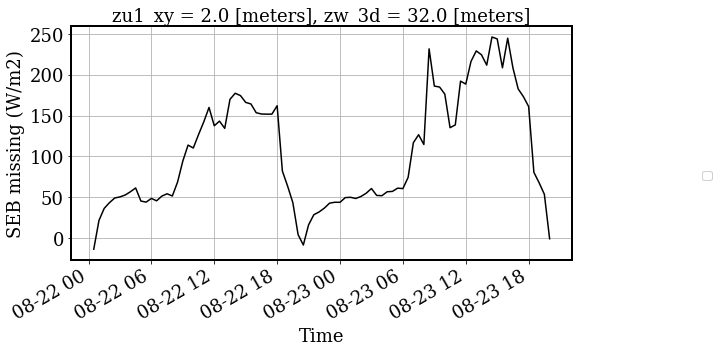

In [104]:
fig = plt.figure(figsize=(10,5))
ax = fig.subplots(1,1)

(H_missing+LE_missing-ghf_simulated['ghf*_xy'].mean('ensemble').mean('tower')).plot(ax=ax,color ='black',x='time')

fig.legend(loc=7,fontsize=12)
ax.set_xlabel('Time',fontsize=18)
ax.set_ylabel('SEB missing (W/m2)',fontsize=18)
#ax.set_ylim([-0.25,0.3])
ax.grid(True)
fig.legend(loc=7,fontsize=12)
fig.tight_layout()
fig.subplots_adjust(right=0.8)

This looks like a more reasonable daytime magnitude..

Maybe make a time series of the dispersive fluxes. won't be so much..

In [109]:
ensemble_member_ds_N03_iop02 = open_concat_member_files(member_num,'DATA_3D_AV_NETCDF_N03slice',iop)
ensemble_member_ds_N03_iop02

['04.ches_IOP2.1455', '05. ches_IOP2.31525', '06.ches_IOP2.1409', '07.ches_IOP2.31095', '1.ches_IOP2.11058', '2.ches_IOP2.20781', '3.ches_IOP2.1521']
Member 8 finished collecting data
Done with member 8  Time elapsed  0.339400514960289 seconds


<xarray.Dataset>
Dimensions:                (x: 2000, time: 88, y: 2000, xu: 2000, yv: 2000,
                            zu_3d: 27, zw_3d: 27, zpc_3d: 10)
Coordinates:
  * x                      (x) float64 3.0 9.0 15.0 ... 1.199e+04 1.2e+04
  * y                      (y) float64 3.0 9.0 15.0 ... 1.199e+04 1.2e+04
  * xu                     (xu) float64 0.0 6.0 12.0 ... 1.199e+04 1.199e+04
  * yv                     (yv) float64 0.0 6.0 12.0 ... 1.199e+04 1.199e+04
  * time                   (time) datetime64[ns] 2019-08-22T00:30:00 ... 2019...
  * zu_3d                  (zu_3d) float64 0.0 2.0 6.0 10.0 ... 94.0 98.0 102.0
  * zw_3d                  (zw_3d) float64 0.0 4.0 8.0 12.0 ... 96.0 100.0 104.0
  * zpc_3d                 (zpc_3d) float64 0.0 2.0 6.0 10.0 ... 26.0 30.0 34.0
Data variables: (12/35)
    E_UTM                  (time, x) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    N_UTM                  (time, y) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    Eu_UTM                 (time, xu) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    Nu_UTM                 (time, y) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    Ev_UTM                 (time, x) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    Nv_UTM                 (time, yv) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    ...                     ...
    wtheta                 (time, zw_3d, y, x) float32 dask.array<chunksize=(14, 27, 2000, 2000), meta=np.ndarray>
    wq                     (time, zw_3d, y, x) float32 dask.array<chunksize=(14, 27, 2000, 2000), meta=np.ndarray>
    ws                     (time, zw_3d, y, x) float32 dask.array<chunksize=(14, 27, 2000, 2000), meta=np.ndarray>
    pcm_heatrate           (time, zpc_3d, y, x) float32 dask.array<chunksize=(14, 10, 2000, 2000), meta=np.ndarray>
    pcm_transpirationrate  (time, zpc_3d, y, x) float32 dask.array<chunksize=(14, 10, 2000, 2000), meta=np.ndarray>
    pcm_latentrate         (time, zpc_3d, y, x) float32 dask.array<chunksize=(14, 10, 2000, 2000), meta=np.ndarray>
Attributes: (12/28)
    title:           PALM 21.10-rc.2  run: ches_IOP2.01  nest-id: 03  host: b...
    Conventions:     CF-1.7
    creation_time:   2022-07-27 14:43:15 -06
    data_content:    3d_av
    version:         2
    origin_time:     2019-08-22 05:00:00 +00
    ...              ...
    references:      
    keywords:        example, PALM-4U
    licence:         
    comment:         Generic crossing example
    time_avg:         1800.0 s avg
    VAR_LIST:        ;u;v;w;e;uu;vv;ww;uv;uw;vw;theta;q;s;rh;wtheta;wq;ws;pcm...

In [123]:
w = ensemble_member_ds_N03_iop02.w.sel(zw_3d=36)
theta = ensemble_member_ds_N03_iop02.theta.sel(zu_3d=34)
q = ensemble_member_ds_N03_iop02.q.sel(zu_3d=34)

In [118]:
w = ensemble_member_ds_2_N03_iop03.w.sel(zw_3d=36)
theta = ensemble_member_ds_2_N03_iop03.theta.sel(zu_3d=34)
q = ensemble_member_ds_2_N03_iop03.q.sel(zu_3d=34)

In [124]:
wtheta_dispersive = ((w - w.mean('x').mean('y'))*(theta - theta.mean('x').mean('y'))).mean('x').mean('y')
wtheta_dispersive = wtheta_dispersive*1.17*1005

wq_dispersive = ((w - w.mean('x').mean('y'))*(q - q.mean('x').mean('y'))).mean('x').mean('y')
wq_dispersive = wq_dispersive*1.17*1005*2501


[########################################] | 100% Completed | 2.43 sms
[########################################] | 100% Completed | 2.02 sms
[########################################] | 100% Completed | 2.53 sms


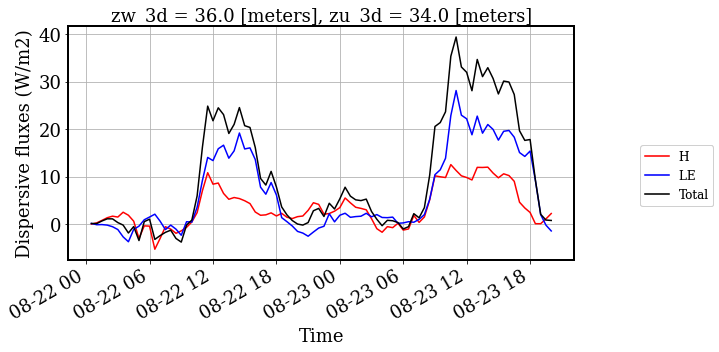

In [125]:
fig = plt.figure(figsize=(10,5))
ax = fig.subplots(1,1)

(wtheta_dispersive).plot(ax=ax,color ='red',x='time', label = 'H ')
(wq_dispersive).plot(ax=ax,color ='blue',x='time', label = 'LE ')

(wtheta_dispersive+wq_dispersive).plot(ax=ax,color ='black',x='time', label = 'Total')

fig.legend(loc=7,fontsize=12)
ax.set_xlabel('Time',fontsize=18)
ax.set_ylabel('Dispersive fluxes (W/m2)',fontsize=18)
ax.grid(True)
fig.legend(loc=7,fontsize=12)
fig.tight_layout()
fig.subplots_adjust(right=0.8)

[########################################] | 100% Completed | 1.73 sms
[########################################] | 100% Completed | 1.82 sms
[########################################] | 100% Completed | 2.33 sms


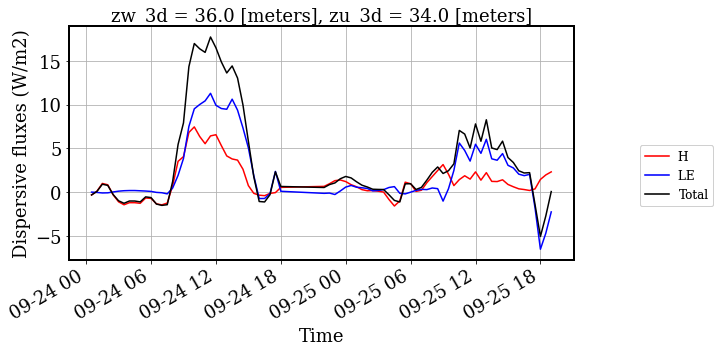

In [122]:
fig = plt.figure(figsize=(10,5))
ax = fig.subplots(1,1)

(wtheta_dispersive).plot(ax=ax,color ='red',x='time', label = 'H ')
(wq_dispersive).plot(ax=ax,color ='blue',x='time', label = 'LE ')

(wtheta_dispersive+wq_dispersive).plot(ax=ax,color ='black',x='time', label = 'Total')

fig.legend(loc=7,fontsize=12)
ax.set_xlabel('Time',fontsize=18)
ax.set_ylabel('Dispersive fluxes (W/m2)',fontsize=18)
#ax.set_ylim([-0.25,0.3])
ax.grid(True)
fig.legend(loc=7,fontsize=12)
fig.tight_layout()
fig.subplots_adjust(right=0.8)